In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [0]:
def range_xy(sill, X, Y):
  percent95 = 0.95*sill
  for i in range(len(X)):
    if(Y[i] >= percent95):
      return X[i]
  return X[-1]

def spherical_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z[(Z.index<=a)]=nugget+(sill-nugget)*(1.5*Z/a-0.5*np.power(Z/a,3))
  Z[(Z.index>a)]=sill
  return np.array(Z)
    
def exponential_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*Z/a))
  return np.array(Z)
  
  
def gaussian_model(data, X, Y,label="gold_grade"):
  nugget=Y[0]
  sill=(data[label]).var()
  a=range_xy(sill,X,Y)
  Z=pd.DataFrame(np.array(range(0, X[-1])))
  Z=nugget+(sill-nugget)*(1-np.exp(-3*np.square(Z)/np.square(a)))
  return np.array(Z)

def mean_absolute_percentage_error(data, gold_grade='gold_grade', estimate='estimate'):
  error_series = (data.apply(lambda row: np.abs((row.gold_grade - row.estimate)/row.gold_grade), axis=1))
  return error_series.sum()*100/len(error_series)

In [0]:
data = pd.read_table("/content/sample_data/gold_samples.dat", sep=" ")
x_train = data.drop(columns=['gold_grade'])
y_train = data['gold_grade']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [0]:
sample_train = (pd.DataFrame({'X': x_train['X'], 'Y': x_train['Y'], 'gold_grade':y_train})).reset_index(drop=True)
sample_test = (pd.DataFrame({'X': x_test['X'], 'Y': x_test['Y'], 'gold_grade':y_test})).reset_index(drop=True)
sample_train.head()

,X,Y,gold_grade
0,-429.81,-24549.17,83.0984
1,-1224.94,-25708.08,129.0898
2,299.55,-24317.43,28.7153
3,-112.12,-24660.56,111.0493
4,-679.25,-24585.97,29.0188


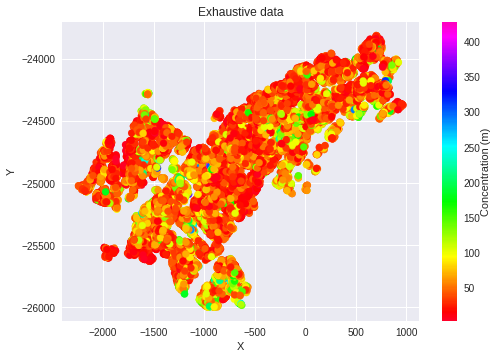

In [0]:
plt.scatter(data['X'], data['Y'], c=data['gold_grade'], cmap='gist_rainbow')
cbar= plt.colorbar()
cbar.set_label("Concentration (m)", labelpad=+1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Exhaustive data")
plt.show()

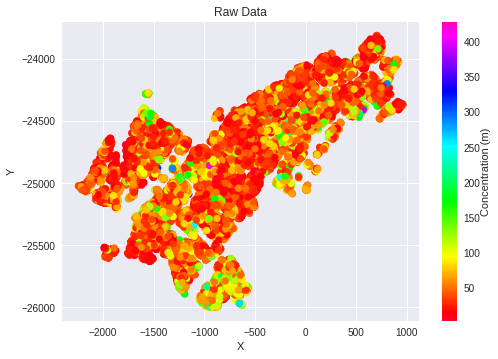

In [0]:
plt.scatter(sample_train['X'], sample_train['Y'], c=sample_train['gold_grade'], cmap='gist_rainbow')
cbar= plt.colorbar()
cbar.set_label("Concentration (m)", labelpad=+1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw Data")
plt.show()

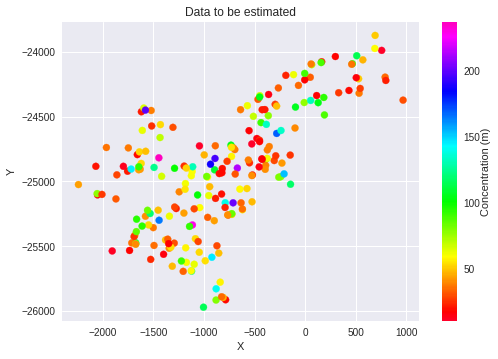

In [0]:
plt.scatter(sample_test['X'], sample_test['Y'], c=sample_test['gold_grade'], cmap='gist_rainbow')
cbar= plt.colorbar()
cbar.set_label("Concentration (m)", labelpad=+1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Data to be estimated")
plt.show()

In [0]:
sample_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20253 entries, 0 to 20252
Data columns (total 3 columns):
X             20253 non-null float64
Y             20253 non-null float64
gold_grade    20253 non-null float64
dtypes: float64(3)
memory usage: 474.8 KB


In [0]:
sample_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 3 columns):
X             1066 non-null float64
Y             1066 non-null float64
gold_grade    1066 non-null float64
dtypes: float64(3)
memory usage: 25.1 KB


In [0]:
sample_train.describe()

,X,Y,gold_grade
count,21105.000000,21105.000000,21105.000000
mean,-779.645116,-24887.681865,53.145847
std,709.067458,487.191202,39.232699
min,-2242.610000,-25999.190000,3.431700
25%,-1342.090000,-25248.780000,26.806500
50%,-838.990000,-24874.110000,42.380500
75%,-252.390000,-24503.440000,67.280400
max,962.770000,-23810.320000,428.295100


In [0]:
sample_test.describe()

,X,Y,gold_grade
count,214.000000,214.000000,214.000000
mean,-814.845140,-24910.306589,58.687563
std,685.259468,472.384446,43.997497
min,-2239.860000,-25970.260000,10.301900
25%,-1347.400000,-25252.752500,28.219050
50%,-851.415000,-24898.995000,45.386100
75%,-385.542500,-24563.642500,75.841975
max,966.520000,-23872.660000,237.264600


In [0]:
from collections import defaultdict
def variogram(data, X = "X", Y = "Y", G="gold_grade", min_angle=0, angle_tolerance=90, no_of_lags = 10, lag_spacing=10, lag_tolerance=5):
    g_values = pd.DataFrame({'distance':[] , 'values':[]})
    x_y_values = defaultdict(lambda:0)
    count = defaultdict(lambda:0)
    for i in range(data.shape[0]):
        if(angle_tolerance >= 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle+angle_tolerance > 90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance-180) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < min_angle-angle_tolerance))) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        elif(min_angle-angle_tolerance < -90):
            var_data = pd.DataFrame(np.array(data[(data.index > i) & (~((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi > min_angle+angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi < 180+min_angle-angle_tolerance))) &(np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        else:
            var_data = pd.DataFrame(np.array(data[(data.index > i) & ((np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi >= min_angle-angle_tolerance) & (np.arctan2(data[Y]-data[Y][i], data[X]-data[X][i])*180/np.pi <= min_angle+angle_tolerance)) & (np.sqrt(np.square(data[X]-data[X][i])+np.square(data[Y]-data[Y][i])) <= no_of_lags*lag_spacing)])).rename(index = str, columns={0:X, 1:Y, 2:'values'})
        var_data[X] -= data[X][i]
        var_data[Y] -= data[Y][i]
        var_data["distance"] = np.linalg.norm(var_data[[X, Y]], axis=1)
        var_data = var_data.drop(columns=[X, Y])
        var_data["values"] = var_data["values"] - data[G][i]
        g_values = g_values.append(var_data, ignore_index = True)
        if(i%100 == 0):
            for j in range(0, no_of_lags*lag_spacing+1, lag_spacing):
                range_array = np.array(g_values[(g_values['distance']>j-lag_tolerance) & (g_values['distance'] <= j+lag_tolerance)]['values'])
                x_y_values[j] += np.sum(np.square(range_array), axis = 0)
                count[j] += range_array.shape[0]
            g_values = pd.DataFrame({'distance':[] , 'values':[]}) 
    x = []
    y = []
    for keys in x_y_values:
        x.append(keys)
        y.append(x_y_values[keys]/(2*count[keys]))
    return(x, y)

In [0]:
def covariance_function(nugget, sill, distance, a, model = "spherical"):
  if(model == "spherical"):
    return ((sill-nugget)*(1-1.5*distance/a+0.5*np.power(distance/a,3)))
  elif(model == "gaussian"):
    return ((sill-nugget)*(np.exp(-3*np.square(distance)/np.square(a))))
  elif(model == "exponential"):
    return ((sill-nugget)*(np.exp(-3*distance/a)))
  
count = 0
    
def find_estimate(data, x, y, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", max_points=4, kriging_type="ordinary"):
  points = pd.DataFrame({X:[], Y:[], G:[] , 'distance':[]})
  df1 = pd.DataFrame(np.array(data[(data[X] >= x) & (data[Y] >= y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] > x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] < y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  df1 = pd.DataFrame(np.array(data[(data[X] < x) & (data[Y] > y)])).rename(index = str, columns={0:X, 1:Y, 2:G})
  df1["distance"] = np.sqrt(np.square(df1[X]-x)+np.square(df1[Y]-y))
  points = points.append(df1.sort_values(["distance"]).head(n=max_points))
  distances = pd.merge(pd.DataFrame({'key':1, 'X1':points[X], 'Y1':points[Y]}), pd.DataFrame({'key':1, 'X2':points[X], 'Y2':points[Y]}))
  distances['distance'] = np.sqrt(np.square(distances['X1']-distances['X2'])+np.square(distances['Y1']-distances['Y2']))
  dist_length = len(distances)
  if(kriging_type == "ordinary"):
    self_cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), np.array(points['distance']),  a, model), (0,1), 'constant', constant_values=(0, 1))
  elif(kriging_type == "block"):
    block_points = (pd.merge(pd.DataFrame({"key":1, "X":np.array(range(int(x)-50,int(x)+50))}), pd.DataFrame({"key":1, "Y":np.array(range(int(y)-50,int(y)+50))}), on='key'))
    b_shape = block_points.shape[0]
    p_shape = points.shape[0]
    block_points = (pd.merge(pd.DataFrame({"key":1, "X1":block_points[X], "Y1":block_points[Y]}), pd.DataFrame({"key":1, "X2":points[X], "Y2":points[Y]}), on='key'))
    block_points["distance"] = block_points.apply(lambda row: np.sqrt(np.square(row.X1-row.X2)+np.square(row.Y1-row.Y2)), axis = 1)
    self_cov_matrix = np.pad(np.average(covariance_function(nugget, (data[G]).var(), np.array(block_points["distance"]).reshape(p_shape, b_shape), a, model), axis = 1), (0,1), 'constant', constant_values=(0, 1))
  cov_matrix = np.pad(covariance_function(nugget, (data[G]).var(), (np.array(distances['distance'])).reshape((int(np.sqrt(dist_length)), int(np.sqrt(dist_length)))), a, model), ((0, 1), (0, 1)), 'constant', constant_values=((0, 1), (0, 1)))
  cov_matrix[-1, -1] = 0
  #print(cov_matrix)
  #print(self_cov_matrix)
  #print(cov_matrix.shape)
  #print(self_cov_matrix.shape)
  weights = np.dot(np.linalg.inv(cov_matrix), self_cov_matrix) 
  #print(weights)
  #print(x, y)
  return(max(0, np.dot(weights[:-1], np.array(points[G]))))
  
  
  
def kriging(sample_train, sample_test, nugget, a, X='X', Y='Y', G='gold_grade', model="spherical", kriging_type="ordinary"):
  sample_test['estimate'] = sample_test.apply(lambda row: find_estimate(sample_train, row.X, row.Y, nugget, a, kriging_type=kriging_type), axis=1)
  return sample_test
  
  

Time taken:  155.9258782863617


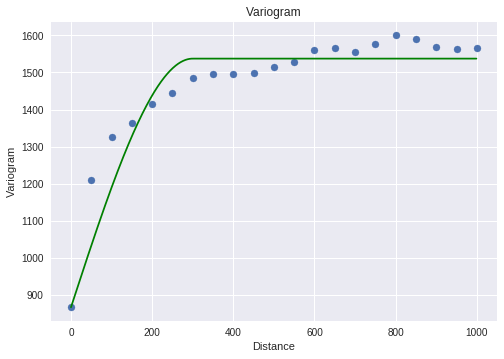

In [0]:
start = time.time()
[X, Y] = variogram(sample_train, no_of_lags=20, lag_spacing = 50, lag_tolerance = 25)
plt.scatter(X, Y)
plt.plot(spherical_model(sample_train, X, Y), 'g-')
#plt.plot(exponential_model(sample_train, X, Y), 'b-')
#plt.plot(gaussian_model(sample_train, X, Y), 'r-')
plt.xlabel("Distance")
plt.ylabel("Variogram")
plt.title("Variogram")
print("Time taken: ", time.time()-start)

In [0]:
start = time.time()
print(find_estimate(sample_train, -1000, -25000, Y[0], range_xy(data['gold_grade'].var(), X, Y), model="spherical"))
print("Time taken: ", time.time()-start)

33.36239328576348
Time taken:  0.04120612144470215


In [0]:
#sample_train.var()
sample_test = kriging(sample_train, sample_test, Y[0], range_xy(sample_train['gold_grade'].var(), X, Y), model="exponential")
sample_test

,X,Y,gold_grade,estimate
0,-1314.90,-25001.97,67.3607,53.093110
1,-651.13,-24474.43,44.4380,40.933527
2,-471.95,-24990.65,23.5428,31.481961
3,-708.31,-25247.86,32.2689,23.212101
4,-1243.92,-25646.47,25.3983,25.975345
5,-223.47,-24723.18,44.3624,27.723991
6,-1401.43,-24678.85,13.8012,16.990453
7,-1621.25,-24851.64,26.8065,52.012645
8,571.22,-23975.36,15.8492,15.780292
9,211.50,-24403.85,32.0047,50.480514


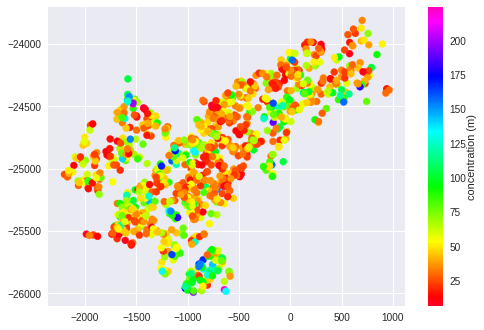

In [0]:
plt.scatter(sample_test['X'], sample_test['Y'], c=sample_test['estimate'], cmap='gist_rainbow')
cbar= plt.colorbar()
cbar.set_label("concentration (m)", labelpad=+1)

In [0]:
print("Mean Absolute Error: ", mean_absolute_error(sample_test['gold_grade'], sample_test['estimate']))
print("Mean Square Error", mean_squared_error(sample_test['gold_grade'], sample_test['estimate']))
print("Score: ", r2_score(sample_test['gold_grade'], sample_test['estimate']))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(sample_test))

Mean Absolute Error:  16.536044633243243
Mean Square Error 639.1444000373077
Score:  0.5895685050706404
Mean Absolute Percentage Error:  35.02512365665203


In [0]:
[X, Y] = variogram(data, min_angle = 90, angle_tolerance = 30, no_of_lags=20, lag_spacing = 50, lag_tolerance = 25)
plt.scatter(X, Y)
plt.xlabel("Distance")
plt.ylabel("Variogram")
plt.title("Variogram")